In [1]:
# 2nd chapter from Metrics Manifesto by R. Seiersen, "translated" to Python.
!wget https://raw.githubusercontent.com/ribsy/mdata/main/tmm_start_small.csv

--2023-03-29 10:18:40--  https://raw.githubusercontent.com/ribsy/mdata/main/tmm_start_small.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 658553 (643K) [text/plain]
Saving to: ‘tmm_start_small.csv.1’

tmm_start_small.csv 100%[===================>] 643.12K  --.-KB/s    in 0.09s   

2023-03-29 10:18:41 (6.62 MB/s) - ‘tmm_start_small.csv.1’ saved [658553/658553]



In [2]:
# create the dataset from csv file and correct the column names: first.seen and last.seen replacing dot with underscore
import pandas as pd
df = pd.read_csv('tmm_start_small.csv')
df.rename(columns = {'first.seen':'first_seen', 'last.seen':'last_seen'}, inplace = True)

In [3]:
df.head()

,idTeam,group,first_seen,last_seen
0,2,1,2020-01-04,2020-01-23
1,2,1,2020-01-18,2020-01-19
2,2,1,2020-07-18,2020-07-19
3,3,1,2020-03-29,2020-04-29
4,3,1,2020-04-23,2020-05-07


In [4]:
# We need two additional columns with delta - the duration of a vulnerability until it's fixed/gone and status - whether it's get censored.

from datetime import datetime as dt
from datetime import timedelta

# Iterate over two columns in dataframe, using `zip`, convert the string to datetime and get the delta+1 day
#df['delta'] = [(dt.strptime(stop,"%Y-%m-%d") - dt.strptime(start,"%Y-%m-%d"))+timedelta(days=1) for start, stop in zip(df['first_seen'],df['last_seen'])]
delta = [(dt.strptime(stop,"%Y-%m-%d") - dt.strptime(start,"%Y-%m-%d"))+timedelta(days=1) for start, stop in zip(df['first_seen'],df['last_seen'])]
# convert dtype64 from nanoseconds to days, otherwise the plot's x axis gets weird numbers
df['delta'] = [x.days for x in delta]
# Iterate over last.seen column and check whether it gets censored 
df['status'] = [1 if (dt.strptime(stop,"%Y-%m-%d") < dt.strptime('2020-12-31',"%Y-%m-%d")) else 0 for stop in df['last_seen']]

In [5]:
df.head()

,idTeam,group,first_seen,last_seen,delta,status
0,2,1,2020-01-04,2020-01-23,20,1
1,2,1,2020-01-18,2020-01-19,2,1
2,2,1,2020-07-18,2020-07-19,2,1
3,3,1,2020-03-29,2020-04-29,32,1
4,3,1,2020-04-23,2020-05-07,15,1


In [6]:
# filter out by start date <= 2020-10-01, idTeam == 1 and group == 1
df_flt = df[(df.idTeam == 1) & (df.group == 1) & (pd.to_datetime(df.first_seen) <= pd.to_datetime('2020-10-01'))]

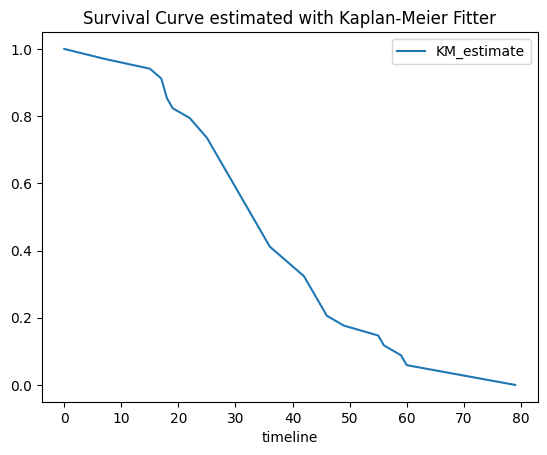

In [7]:
# Survival function KMF
import datetime
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
kmf.fit(durations=df_flt.delta, event_observed=df_flt.status)# Plot the survival function
kmf.survival_function_.plot()
plt.title('Survival Curve estimated with Kaplan-Meier Fitter')
plt.show()

In [8]:
# Print survival probabilities
kmf.survival_function_.head()

,KM_estimate
timeline,
0.0,1.000000
7.0,0.970588
15.0,0.941176
17.0,0.911765
18.0,0.852941


In [9]:
kmf.median_survival_time_

34.0

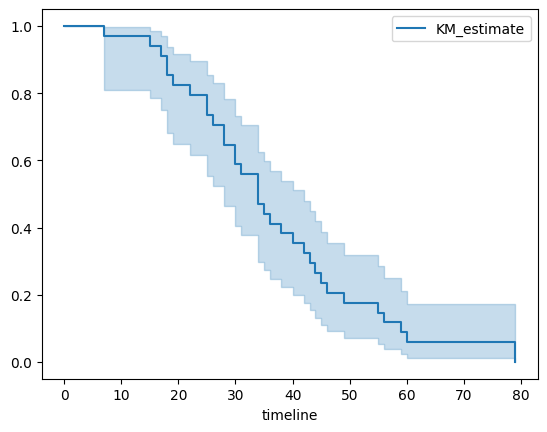

In [10]:
# Plot the survival function with confidence intervals
kmf.plot_survival_function()
plt.show()